In [117]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
from src.models import TranAD, iTransformer
import torch

In [ ]:
# from cycler import cycler
# plt.rcParams['axes.prop_cycle'] = cycler('color', ['#17becf','#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
# plt.style.use([hep.style.ROOT, hep.style.firamath])

In [118]:
iTransf_n_windows = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 1000, 2000]
TranAD_n_windows = [10, 20, 30, 40, 50, 60, 70]

iTransf_q =  [0.5, 0.25, 0.1, 0.075, 0.05, 1e-2, 1e-3, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]
TranAD_q = [0.5, 0.25, 0.1, 0.075, 0.05, 1e-2, 1e-3, 1e-4, 5e-5, 1e-5, 5e-6, 1e-6, 1e-7]

In [119]:
N = 25
dataset = 'SMAP_new'
less = False
plot_path = './studies2.3/plots'
studies_path = './studies2.3'

In [87]:
loader = []
for file in ['train', 'test', 'labels']:
    if dataset == 'SMD': file = 'machine-1-1_' + file
    if dataset == 'SMAP': file = 'P-1_' + file
    if dataset == 'SMAP_new': file = 'P-1_' + file
    if dataset == 'MSL': file = 'C-1_' + file
    if dataset == 'MSL_new': file = 'C-1_' + file
    if dataset == 'UCR': file = '136_' + file
    if dataset == 'NAB': file = 'ec2_request_latency_system_failure_' + file
    loader.append(np.load(os.path.join(f'processed/{dataset}', f'{file}.npy')))
train_data = loader[0]
test_data = loader[1]
true_labels = loader[2]
print(train_data, train_data[0].shape, train_data.shape)
print(test_data, test_data[0].shape)

[[-0.52310245  0.          0.         ...  0.          0.
   0.        ]
 [-0.68878789  0.          0.         ...  0.          0.
   0.        ]
 [-0.55493723  0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.72568717  0.          0.         ...  0.          0.
   0.        ]
 [-0.6895113   0.          0.         ...  0.          0.
   0.        ]
 [-0.70976989  0.          0.         ...  0.          0.
   0.        ]] (25,) (2872, 25)
[[-0.69509243  0.          0.         ...  0.          0.
   0.        ]
 [-0.68563529  0.          0.         ...  0.          0.
   0.        ]
 [-0.72564594  0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.31608343  0.          0.         ...  0.          0.
   0.        ]
 [-0.29716948  0.          0.         ...  0.          0.
   0.        ]
 [-0.73219298  0.          0.         ...  0.          0.
   0.        ]] (25,)


In [ ]:
TranAD_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
TranAD_labels = []
loss = np.zeros((len(TranAD_n_windows), N))

print(loss.shape, loss[0].shape)
for i, elem in enumerate(TranAD_n_windows):
    path = f'{studies_path}/TranAD_{dataset}_2/n_window{elem}/results'
    model_path = f'{studies_path}/n_window{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = TranAD(N, elem).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    TranAD_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(TranAD_labels[0].shape, len(TranAD_labels))
# print(TranAD_all_res)

In [ ]:
iTransf_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(iTransf_n_windows), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_n_windows):
    path = f'{studies_path}/iTransformer_{dataset}_2/n_window{elem}/results'
    model_path = f'{studies_path}/n_window{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = iTransformer(N, elem).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    iTransf_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size
iTransf_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(iTransf_q), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_q):
    path = f'{studies_path}/iTransformer_{dataset}/detection_lvl_{elem}/results'
    model_path = f'{studies_path}/iTransformer_{dataset}/detection_lvl_{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = iTransformer(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    iTransf_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    iTransf_all_res['f1'].append(df_res['f1'])
    iTransf_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    iTransf_labels.append(np.array(df_labels))
iTransf_all_res['loss'] = loss
print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

In [ ]:
# same as previous but for detection level instead of window size
TranAD_all_res = {'ROC/AUC': [], 'f1': [], 'total_loss': [], 'loss': [], 'parameters': []}
loss = np.zeros((len(TranAD_q), N))
TranAD_labels = []

for i, elem in enumerate(TranAD_q):
    path = f'{studies_path}/TranAD_{dataset}/detection_lvl_{elem}/results'
    model_path = f'{studies_path}/TranAD_{dataset}/detection_lvl_{elem}/checkpoints/model.ckpt'

    checkpoint = torch.load(model_path)
    model = TranAD(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    accuracy_list = checkpoint['accuracy_list']    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/all_res.csv')
    df_loss = pd.read_csv(f'{path}/test_loss.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res)
    TranAD_all_res['ROC/AUC'].append(df_res['ROC/AUC'])
    TranAD_all_res['f1'].append(df_res['f1'])
    TranAD_all_res['total_loss'].append(np.mean(df_loss))
    loss[i] = np.mean(df_loss, axis=0)
    TranAD_labels.append(np.array(df_labels))
TranAD_all_res['loss'] = loss
print(TranAD_labels[0].shape, len(TranAD_labels))


In [120]:
# same as previous but for detection level instead of window size + new outputs
iTransf_all_res = {'AUC_local': [], 'AUC_global': [], 'f1_local': [], 'f1_global': [], 'parameters': []}
loss = np.zeros((len(iTransf_q), N))
iTransf_labels = []

for i, elem in enumerate(iTransf_q):
    path = f'{studies_path}/iTransformer_{dataset}/detectionlvl_{elem}/results'
    model_path = f'{studies_path}/iTransformer_{dataset}/detectionlvl_1e-05/checkpoints/model.ckpt'
   
    checkpoint = torch.load(model_path)
    model = iTransformer(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    iTransf_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/res.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')

    iTransf_all_res['AUC_local'].append(df_res['ROC/AUC'].iloc[-2])
    iTransf_all_res['AUC_global'].append(df_res['ROC/AUC'].iloc[-1])
    iTransf_all_res['f1_local'].append(df_res['f1'].iloc[-2])
    iTransf_all_res['f1_global'].append(df_res['f1'].iloc[-1])
    # print(iTransf_all_res)
    iTransf_labels.append(np.array(df_labels))

print(iTransf_labels[0].shape, len(iTransf_labels))
# print(iTransf_all_res)

total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
total params: 47916, trainable params: 47916
(8505, 2) 13


In [121]:
# same as previous but for detection level instead of window size + new outputs
TranAD_all_res = {'AUC_local': [], 'AUC_global': [], 'f1_local': [], 'f1_global': [], 'parameters': []}
loss = np.zeros((len(TranAD_q), N))
TranAD_labels = []

for i, elem in enumerate(TranAD_q):
    path = f'{studies_path}/TranAD_{dataset}/detectionlvl_{elem}/results'
    model_path = f'{studies_path}/TranAD_{dataset}/detectionlvl_1e-05/checkpoints/model.ckpt'
   
    checkpoint = torch.load(model_path)
    model = TranAD(N, 10).double()
    model.load_state_dict(checkpoint['model_state_dict'])
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'total params: {total_params}, trainable params: {trainable_params}')
    TranAD_all_res['parameters'].append(trainable_params)

    df_res = pd.read_csv(f'{path}/res.csv')
    df_labels = pd.read_csv(f'{path}/pred_labels.csv')
    # print(df_res['f1'])

    TranAD_all_res['AUC_local'].append(df_res['ROC/AUC'].iloc[-2])
    TranAD_all_res['AUC_global'].append(df_res['ROC/AUC'].iloc[-1])
    TranAD_all_res['f1_local'].append(df_res['f1'].iloc[-2])
    TranAD_all_res['f1_global'].append(df_res['f1'].iloc[-1])
    # print(iTransf_all_res)
    TranAD_labels.append(np.array(df_labels))

print(TranAD_labels[0].shape, len(TranAD_labels))
# print(TranAD_all_res)

total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
total params: 57273, trainable params: 57273
(8505, 2) 13


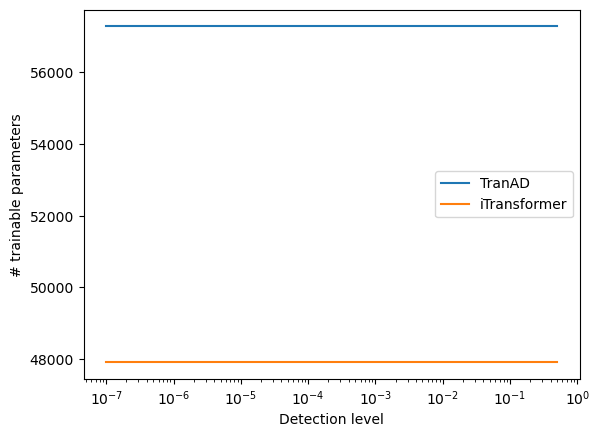

In [122]:
plt.plot(TranAD_q, TranAD_all_res['parameters'], label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('# trainable parameters')
plt.xscale('log')
plt.legend()
plt.savefig(f'{plot_path}/param.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['parameters'], label='TranAD')
# plt.plot(TranAD_n_windows, iTransf_all_res['parameters'][:len(TranAD_n_windows)], label='iTransformer')
plt.plot(iTransf_n_windows, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('# trainable parameters')
plt.legend()
plt.savefig(f'{plot_path}/param.png', dpi=300)


In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['parameters'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['parameters'][:len(TranAD_n_windows)], label='iTransformer')
# plt.plot(iTransf_n_windows, iTransf_all_res['parameters'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('# trainable parameters')
plt.legend()
plt.savefig(f'{plot_path}/param_zoom.png', dpi=300)


In [ ]:
# same plots but zoomed
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['ROC/AUC'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/rocauc_zoom2.png', dpi=300)
plt.clf()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['f1'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/f1_zoom2.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['ROC/AUC'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['ROC/AUC'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/rocauc_2.png', dpi=300)
plt.clf()

plt.plot(TranAD_n_windows, TranAD_all_res['f1'], label='TranAD')
plt.plot(iTransf_n_windows, iTransf_all_res['f1'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('f1 score')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/f1_2.png', dpi=300)

In [ ]:
# same but with detection level q
plt.plot(TranAD_q, TranAD_all_res['ROC/AUC'], ':o', label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['ROC/AUC'], ':o', label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/rocauc.png', dpi=300)
plt.clf()

plt.plot(TranAD_q, TranAD_all_res['ROC/AUC'], ':o', label='TranAD')
plt.plot(iTransf_q, iTransf_all_res['f1'], ':o', label='iTransformer')
plt.xlabel('Detection level')
plt.ylabel('F1 score')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/f1.png', dpi=300)

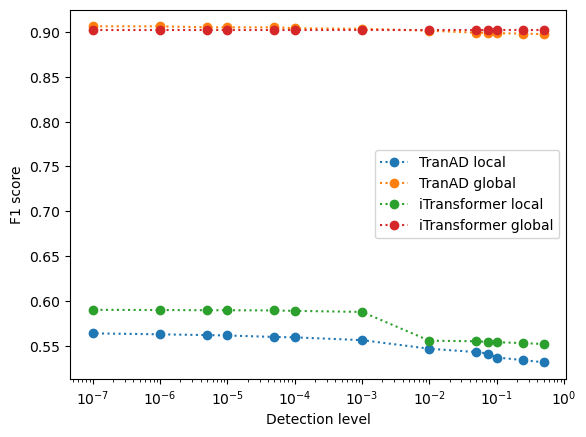

In [124]:
# same but with detection level q + new outputs
plt.plot(TranAD_q, TranAD_all_res['AUC_local'], ':o', label='TranAD local')
plt.plot(TranAD_q, TranAD_all_res['AUC_global'], ':o', label='TranAD global')
plt.plot(iTransf_q, iTransf_all_res['AUC_local'], ':o', label='iTransformer local')
plt.plot(iTransf_q, iTransf_all_res['AUC_global'], ':o', label='iTransformer global')
plt.xlabel('Detection level')
plt.ylabel('ROC AUC')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/rocauc.png', dpi=300)
plt.clf()

plt.plot(TranAD_q, TranAD_all_res['f1_local'], ':o', label='TranAD local')
plt.plot(TranAD_q, TranAD_all_res['f1_global'], ':o', label='TranAD global')
plt.plot(iTransf_q, iTransf_all_res['f1_local'], ':o', label='iTransformer local')
plt.plot(iTransf_q, iTransf_all_res['f1_global'], ':o', label='iTransformer global')
plt.xlabel('Detection level')
plt.ylabel('F1 score')
plt.xscale('log')
plt.legend()
# plt.show()
plt.savefig(f'{plot_path}/f1.png', dpi=300)

In [ ]:
plt.plot(TranAD_n_windows, TranAD_all_res['total_loss'], label='TranAD')
# plt.plot(iTransf_n_windows, iTransf_all_res['total_loss'], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('test loss')
plt.title('total test loss over all dimensions')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/total_loss_TranAD.png', dpi=300)


plt.plot(TranAD_n_windows, TranAD_all_res['total_loss'], label='TranAD')
plt.plot(TranAD_n_windows, iTransf_all_res['total_loss'][:len(TranAD_n_windows)], label='iTransformer')
plt.xlabel('window size')
plt.ylabel('test loss')
plt.title('total test loss over all dimensions')
plt.legend()
plt.show()
# plt.savefig(f'{plot_path}/total_loss_both.png', dpi=300)

In [ ]:
print(TranAD_all_res['loss'][:,0])
for dim in range(N):
	a_s = TranAD_all_res['loss'][:,dim]
	plt.plot(TranAD_n_windows, a_s, label=f'dim = {dim}')
	plt.xlabel('window size')
	plt.ylabel('Test loss')
	plt.title(f'Average loss for dim = {dim}')
	# plt.legend()
	# plt.savefig(f'{path}/{name}.png', dpi=300)
	plt.show()

In [ ]:
for dim in range(N):
	a_s = iTransf_all_res['loss'][:,dim]
	plt.plot(iTransf_n_windows, a_s)
	plt.xlabel('window size')
	plt.ylabel('Test loss')
	plt.title(f'Average loss for dim = {dim}')
	plt.tight_layout()
	plt.show()

In [ ]:
for dim in range(N):
	fig, axs = plt.subplots(1, 2, figsize=(16, 8))
	a_s1 = TranAD_all_res['loss'][:,dim]
	a_s2 = iTransf_all_res['loss'][:,dim]
	axs[0].plot(TranAD_n_windows, a_s1, label=f'dim = {dim}')
	axs[1].plot(iTransf_n_windows, a_s2, label=f'dim = {dim}')
	axs[0].set_title('TranAD')
	axs[1].set_title('iTransformer')
	fig.supxlabel('window size')
	fig.supylabel('Test loss')
	fig.suptitle(f'Average loss for dim = {dim}')
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'{plot_path}/test_loss_dim{dim}.png', dpi=300)
	# plt.close()

In [ ]:
for dim in range(N):
	# print('looking at dimension: ', dim)
	pred1 = []
	pred2 = []
	for i in range(len(TranAD_n_windows)):
		pred1.append(TranAD_labels[i][:,dim])
	for i in range(len(iTransf_n_windows)):
		pred2.append(iTransf_labels[i][:,dim])
	true = np.array(true_labels[0][:,dim]).T
	true = true[np.newaxis, :]

	fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [3, 6, 1]})
	im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[1].imshow(pred2, origin='lower', aspect='auto')
	axs[2].imshow(true, origin='lower', aspect='auto')
	axs[0].set_title('Anomaly labels predicted with TranAD')
	# axs[0].set_ylabel('window size')
	axs[0].set_yticks(ticks=np.arange(len(TranAD_n_windows)), labels=TranAD_n_windows)
	axs[1].set_title('Anomaly labels predicted with iTransformer')
	# axs[1].set_ylabel('window size')
	axs[1].set_yticks(ticks=np.arange(len(iTransf_n_windows)), labels=iTransf_n_windows)
	axs[2].set_title('True labels')
	axs[2].set_yticks(ticks=[0])
	fig.supxlabel('Timestamp')
	fig.supylabel('Window size')
	fig.suptitle(f'dim = {dim}')
	plt.tight_layout()
	plt.show()
	# plt.savefig(f'{plot_path}/alabels_dim{dim}.png', dpi=300)
	plt.close()


In [ ]:
# same but for detection level
for dim in range(N):
	pred1 = []
	pred2 = []
	for i in range(len(TranAD_q)):
		pred1.append(TranAD_labels[i][:,dim])
	for i in range(len(iTransf_q)):
		pred2.append(iTransf_labels[i][:,dim])
	true = np.array(true_labels[0][:,dim]).T
	true = true[np.newaxis, :]

	fig, axs = plt.subplots(3, 1, figsize=(15,6), sharex=True, gridspec_kw={'height_ratios': [3, 5, 1]})
	im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[0].imshow(pred1, origin='lower', aspect='auto')
	axs[1].imshow(pred2, origin='lower', aspect='auto')
	axs[2].imshow(true, origin='lower', aspect='auto')
	axs[0].set_title('Anomaly labels predicted with TranAD')
	axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
	axs[1].set_title('Anomaly labels predicted with iTransformer')
	axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
	axs[2].set_title('True anomaly labels')
	axs[2].set_yticks(ticks=[1e-5])
	fig.supxlabel('Timestamp')
	fig.supylabel('Detection level')
	fig.suptitle(f'Dim = {dim}')
	plt.tight_layout()
	# plt.show()
	plt.savefig(f'{plot_path}/alabels_dim{dim}.png', dpi=300)
	plt.close()


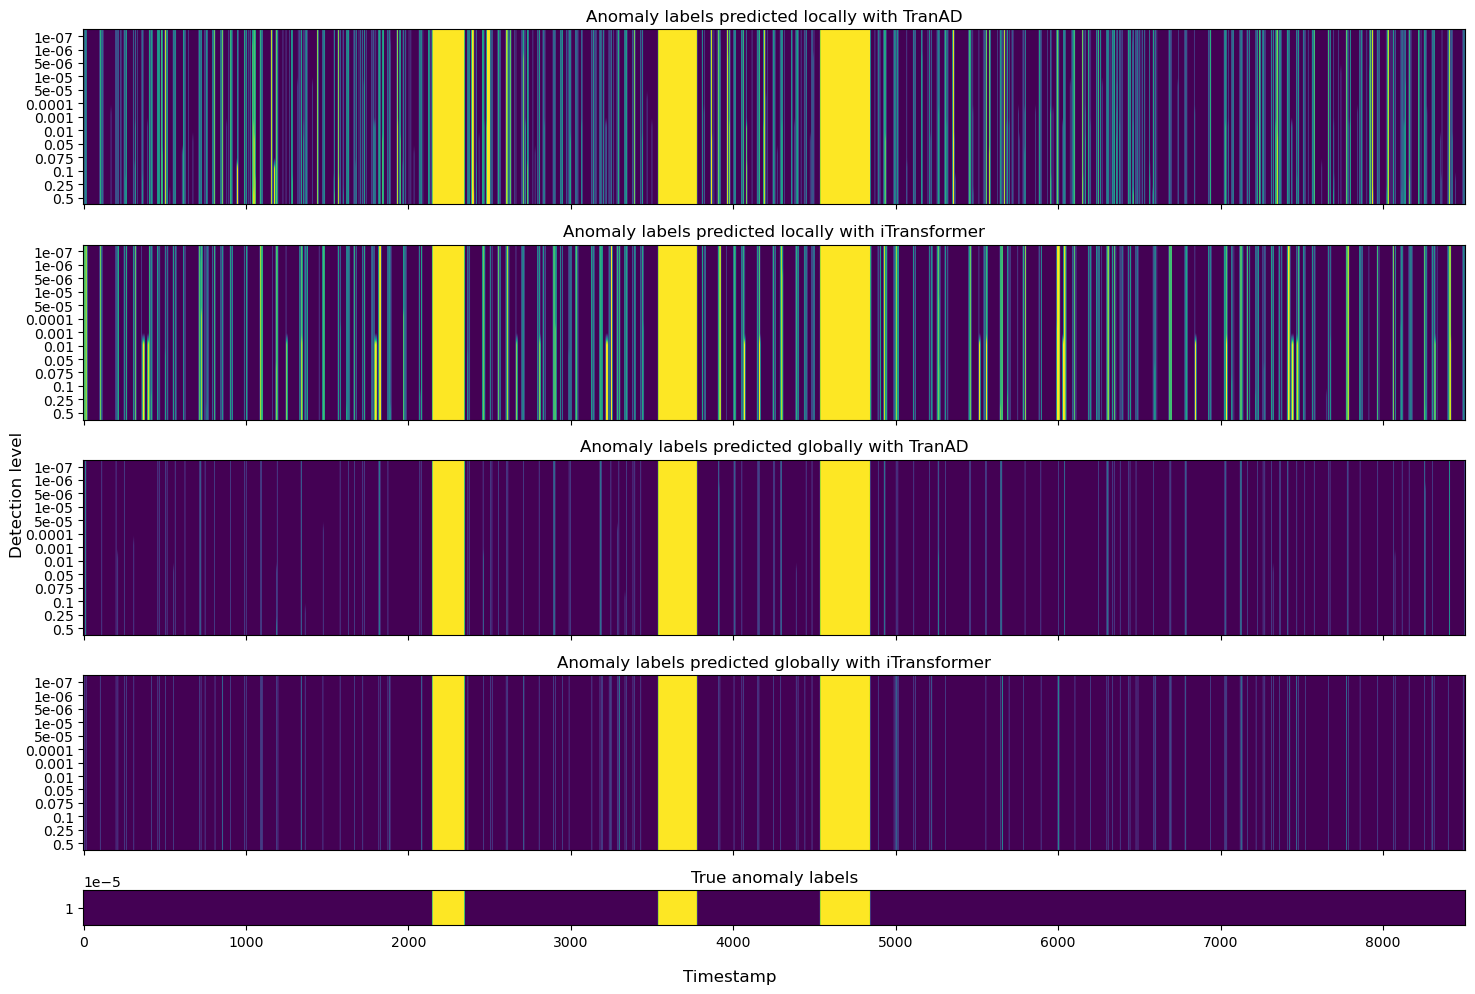

In [125]:
# same but for detection level + local vs global 
pred1 = []
pred2 = []
pred3 = []
pred4 = []

for i in range(len(TranAD_q)):
    pred1.append(TranAD_labels[i][:, 0])
    pred3.append(TranAD_labels[i][:, 1])
for i in range(len(iTransf_q)):
    pred2.append(iTransf_labels[i][:, 0])
    pred4.append(iTransf_labels[i][:, 1])
true = np.array(true_labels[:, 0]).T
true = true[np.newaxis, :]

fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [5, 5, 5, 5, 1]})
im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(pred3, origin='lower', aspect='auto')
axs[3].imshow(pred4, origin='lower', aspect='auto')
axs[4].imshow(true, origin='lower', aspect='auto')

axs[0].set_title('Anomaly labels predicted locally with TranAD')
axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[1].set_title('Anomaly labels predicted locally with iTransformer')
axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
axs[2].set_title('Anomaly labels predicted globally with TranAD')
axs[2].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[3].set_title('Anomaly labels predicted globally with iTransformer')
axs[3].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)

axs[4].set_title('True anomaly labels')
axs[4].set_yticks(ticks=[1e-5])
fig.supxlabel('Timestamp')
fig.supylabel('Detection level')
plt.tight_layout()
# plt.show()
plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)
# plt.close()


In [ ]:
# same but for detection level
true_all = (np.sum(true_labels[0], axis=1) >= 1) + 0
pred1 = (np.sum(TranAD_labels, axis=2) >= 1) + 0
pred2 = (np.sum(iTransf_labels, axis=2) >= 1) + 0
true_all = true_all[np.newaxis, :]

fig, axs = plt.subplots(3, 1, figsize=(15,6), sharex=True, gridspec_kw={'height_ratios': [3,5,1]})
im1 = axs[0].imshow(pred2, origin='lower', aspect='auto')
axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(true, origin='lower', aspect='auto')
axs[0].set_title('Anomaly labels predicted with TranAD')
axs[0].set_yticks(ticks=np.arange(len(TranAD_q)), labels=TranAD_q)
axs[1].set_title('Anomaly labels predicted with iTransformer')
axs[1].set_yticks(ticks=np.arange(len(iTransf_q)), labels=iTransf_q)
axs[2].set_title('True anomaly labels')
axs[2].set_yticks(ticks=[1e-5])
fig.supxlabel('Timestamp')
fig.supylabel('Detection level')
fig.suptitle(f'Anomalies summed over all dimensions')
plt.tight_layout()
plt.show()
# plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)


In [ ]:
true_all = (np.sum(true_labels[0], axis=1) >= 1) + 0
pred1 = (np.sum(TranAD_labels, axis=2) >= 1) + 0
pred2 = (np.sum(iTransf_labels, axis=2) >= 1) + 0
true_all = true_all[np.newaxis, :]

fig, axs = plt.subplots(3, 1, figsize=(20,10), sharex=True, gridspec_kw={'height_ratios': [3, 6, 1]})
im1 = axs[0].imshow(pred1, origin='lower', aspect='auto')
axs[1].imshow(pred2, origin='lower', aspect='auto')
axs[2].imshow(true_all, origin='lower', aspect='auto')
axs[0].set_title('anomaly labels predicted with TranAD')
# axs[0].set_ylabel('window size')
axs[0].set_yticks(ticks=np.arange(len(TranAD_n_windows)), labels=TranAD_n_windows)
axs[1].set_title('anomaly labels predicted with iTransformer')
# axs[1].set_ylabel('window size')
axs[1].set_yticks(ticks=np.arange(len(iTransf_n_windows)), labels=iTransf_n_windows)
axs[2].set_title('true labels')
axs[2].set_yticks(ticks=[0])
fig.supxlabel('time stamp')
fig.supylabel('window size')
fig.suptitle(f'anomalies summed over all dimensions')
plt.tight_layout()
plt.show()
# plt.savefig(f'{plot_path}/alabels_all.png', dpi=300)


In [ ]:
loader = []
for file in ['train', 'test']:
    if dataset == 'SMD': file = 'machine-1-1_' + file
    if dataset == 'SMAP': file = 'P-1_' + file
    if dataset == 'SMAP_new': file = 'P-1_' + file
    if dataset == 'MSL': file = 'C-1_' + file
    if dataset == 'MSL_new': file = 'C-1_' + file
    if dataset == 'UCR': file = '136_' + file
    if dataset == 'NAB': file = 'ec2_request_latency_system_failure_' + file
    loader.append(np.load(os.path.join(f'processed/{dataset}', f'{file}.npy')))
train_data = loader[0]
test_data = loader[1]
print(train_data, train_data[0].shape, train_data.shape)
print(test_data, test_data[0].shape)

In [ ]:
for dim in range(len(test_data[0])):
    plt.plot(test_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()
    # plt.savefig(f'plots_data/{dataset}_train_dim{dim}.png', dpi=300)
    plt.close()
    if np.all(train_data[:, dim]==0):
        if np.all(test_data[:, dim]==0):
            print('0 test and train data: ', dim)
        else:
            print('0 training: ', dim)

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages


In [ ]:
pdf = PdfPages(f'plots_data/{dataset}_train.pdf')
for dim in range(len(train_data[0])):
    fig, axs = plt.subplots(1, 1, figsize=(6,2))
    plt.plot(train_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
pdf.close()

In [ ]:
pdf = PdfPages(f'plots_data/{dataset}_test.pdf')
for dim in range(len(test_data[0])):
    fig, axs = plt.subplots(1, 1, figsize=(6,2))
    plt.plot(test_data[:, dim])
    plt.title(f'{dataset}: Dim = {dim}')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()
pdf.close()